# Multimode gmm
Created by: Daniel L. Marino (marinodl@vcu.edu)

Description: gaussian mixture model implementation on tensorflow, the objective is a multimode gaussian distribution. 

This file serves as a visual test for the gmm extension modules

In [1]:
import tensorflow as tf
import numpy as np
import collections
from twodlearn.tf_lib.datasets.generic_dataset import Datasets
from twodlearn.tf_lib.GMM import *

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Create dataset

In [2]:

def gmm_sampling(mu, sigma, w, n_samples=1):
    # generates random vectors, sampled from a gausian mixture model
    #  
    #     - mu: 3d tensor containing the means for the gaussians.
    #           the "depth" dimention (3rd) is used to index the
    #           gaussians.    [ kernel_id, dim]
    #     - sigma: 3d tensor containing the covariance matrix of the
    #              gaussians. [ kernel_id, dim] for diagonal matrices
    #     - w: vector in form of a 3d tensor containing the weights
    #          for each one of the gaussians, they have to sum one. 
    #          [kernel_id]
    n_kernels = mu.shape[0]
    n_dim = mu.shape[1]
    
    # random sample the kernel from which the output samples are going
    # to be drawn
    kernel_id= np.argmax(np.random.multinomial(1, w, size=[n_samples]), axis=1 )
    
    out = np.zeros([n_samples, n_dim])
    for i in range(n_samples):
        out[i,:]= np.random.multivariate_normal(mu[kernel_id[i],:], np.diag(sigma[kernel_id[i],:])) # if diagonal
    
    return out;
    
    

Data shape:  (1000, 2)


<IPython.core.display.Javascript object>


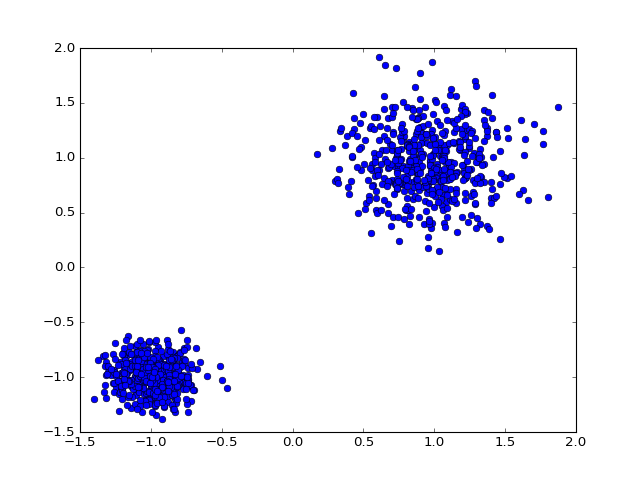

In [3]:
n_samples = 1000

n_kernels_r = 2
n_dim = 2
mu_r = np.array([[1, 1], [10, 10]])
sigma_r = np.array([[0.5, 0.5], [2, 2]])
w_r = [1/n_kernels_r]*n_kernels_r # has to sum to one

# random sample from reference distribution
aux_x = gmm_sampling(mu_r, sigma_r, w_r, n_samples);

# build the dataset
data = Datasets(aux_x)
data.normalize()
print('Data shape: ', data.train.x.shape)

# plot
plt.plot(data.train.x[:,0], data.train.x[:,1], 'o')

## 2. Model definition

In [4]:
sess = tf.InteractiveSession()

In [5]:
n_kernels = 2

gmm_x = tf.placeholder( tf.float32, shape=(n_samples, n_dim))

gmm_w= tf.Variable(tf.truncated_normal( [1, n_kernels + 2*n_kernels*n_dim ], stddev=1.0),
                   name= 'gmm_weights'
                  )
gmm_params = GmmParamsLayer(n_dim, n_kernels, diagonal= True)
gmm_model = GmmModel(n_dim, n_kernels, diagonal= True)

In [6]:
# transform parameters to 'valid' parameters
mu_r, sigma_r, w_r = gmm_params.evaluate(gmm_w)

# evaluate the gaussian mixture model using the 'valid' parameters
gmm_out = gmm_model.evaluate(gmm_x, mu_r, sigma_r, w_r)

# compute the loss of the gmm
gmm_loss = tf.reduce_sum(-tf.log(gmm_out + 0.00000001))

# Optimizer.
optimizer = tf.train.AdamOptimizer(0.05).minimize(gmm_loss) #0.001

In [7]:
print('mu shape:', mu_r.get_shape())
print('sigma shape:', sigma_r.get_shape())
print('w shape:', w_r.get_shape())

print('out shape:', gmm_out.get_shape())

print('loss shape:', gmm_loss.get_shape())


mu shape: (1, 2, 2)
sigma shape: (1, 2, 2)
w shape: (1, 2)
out shape: (1000,)
loss shape: ()


## 3. Training

In [8]:
num_steps = 300 #1000
n_logging = 10
n_test_logg = 10

tf.initialize_all_variables().run()
print('Initialized')

mean_loss= 0
train_accuracy= 0
for step in range(num_steps):   
    
    _, l = sess.run([optimizer, gmm_loss],feed_dict={gmm_x : data.train.x})
    mean_loss += l    
    
    
    if step%n_logging == 0:                
        print(step, ' | loss:', mean_loss/n_logging)
        mean_loss= 0

Initialized
0  | loss: 608.891308594
10  | loss: 5372.01879883
20  | loss: 4599.7328125
30  | loss: 3796.7348877
40  | loss: 2496.34223633
50  | loss: 1287.22402954
60  | loss: 224.922134972
70  | loss: -559.716300964
80  | loss: -1054.06158447
90  | loss: -1249.32819824
100  | loss: -1279.43686523
110  | loss: -1277.7552124
120  | loss: -1282.5880249
130  | loss: -1285.59709473
140  | loss: -1285.83078613
150  | loss: -1285.85819092
160  | loss: -1285.98085937
170  | loss: -1286.01229248
180  | loss: -1286.01166992
190  | loss: -1286.01557617
200  | loss: -1286.01734619
210  | loss: -1286.01741943
220  | loss: -1286.01751709
230  | loss: -1286.01756592
240  | loss: -1286.01761475
250  | loss: -1286.01756592
260  | loss: -1286.01756592
270  | loss: -1286.01760254
280  | loss: -1286.01759033
290  | loss: -1286.01759033


## 4. Plot

In [9]:
n_plot= [20, 20];

# for testing
n_test= n_plot[0]*n_plot[1];
gmm_x_test = tf.placeholder( tf.float32, shape=(n_test, n_dim))

# evaluate the gaussian mixture model using the 'valid' parameters
gmm_out_test = gmm_model.evaluate(gmm_x_test, mu_r, sigma_r, w_r)

mu: [[[ 0.96005601  0.95797229]
  [-0.98732036 -0.98517752]]] sigma: [[[ 0.04011819  0.04553658]
  [ 0.01159801  0.01019446]]] w: [[ 0.50699943  0.49300057]]
(20, 20)


<IPython.core.display.Javascript object>


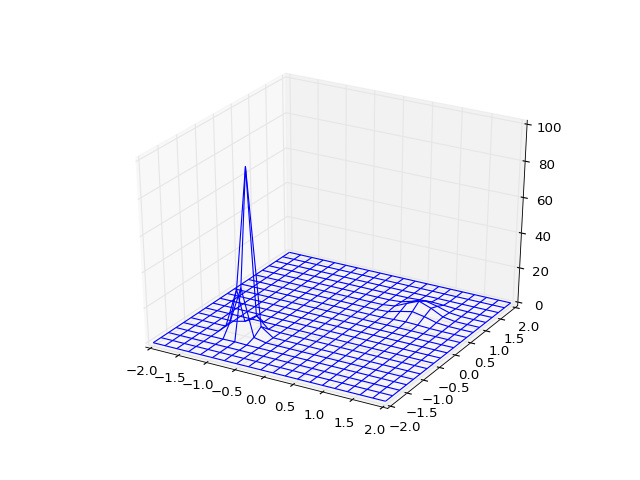

In [10]:

xv, yv = np.meshgrid(np.linspace(-2, 2, n_plot[1]), np.linspace(-2, 2, n_plot[0]))

x_plot = np.stack([xv.transpose(), yv.transpose()], 2)

x_plot = np.reshape(x_plot, [-1,2])

[p_plot, mu_out, sigma_out, w_out,] = sess.run([gmm_out_test, mu_r, sigma_r, w_r],feed_dict= {gmm_x_test : x_plot})
print('mu:', mu_out, 'sigma:', sigma_out, 'w:', w_out)


p_plot = np.reshape(p_plot, [n_plot[1], n_plot[0]])
print(p_plot.shape)

# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xv, yv, p_plot)

